In [93]:
from scipy.spatial.transform import Rotation 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display

In [94]:
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

def projectpoints(K, R, t, Q):
    """project 3D points to 2D"""
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ Rt @ PiInv(Q))

def crossOp(a:np.ndarray) -> np.ndarray:
    """crossproduct operator"""
    x = a[0].item()
    y = a[1].item()
    z = a[2].item()
    return np.array([[0, -z, y], [z, 0, -x], [-y, x, 0]])

In [95]:
R = np.array([[np.sqrt(1/2), -np.sqrt(1/2), 0],
              [np.sqrt(1/2), np.sqrt(1/2), 0],
                [0, 0, 1]])
f = 1000; beta = 0; alpha = 1; dx = 0.5*1920; dy = 0.5*1080
K = np.array([[f, beta*f, dx],
              [0, alpha*f, dy],
              [0, 0, 1]])
t = np.array([[0, 0, 10]]).T

In [96]:
# set numpy to print in a more readable way
# np.get_printoptions()
# np.set_printoptions(precision=4)
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [97]:
# 4.1 find the projection matrix P and the projections q
P = K @ np.concatenate((R, t), axis=1)
display(P)
# all the projections are te possible point that can be created
Q000 = np.array([[0, 0, 0]]).T
Q001 = np.array([[0, 0, 1]]).T
Q010 = np.array([[0, 1, 0]]).T
Q011 = np.array([[0, 1, 1]]).T
Q100 = np.array([[1, 0, 0]]).T
Q101 = np.array([[1, 0, 1]]).T
Q110 = np.array([[1, 1, 0]]).T
Q111 = np.array([[1, 1, 1]]).T
all_points = [Q000, Q001, Q010, Q011, Q100, Q101, Q110, Q111]
projected_points = [projectpoints(K, R, t, Q) for Q in all_points]
projected_points

array([[707.107, -707.107, 960.000, 9600.000],
       [707.107, 707.107, 540.000, 5400.000],
       [0.000, 0.000, 1.000, 10.000]])

[array([[960.000],
        [540.000]]),
 array([[960.000],
        [540.000]]),
 array([[889.289],
        [610.711]]),
 array([[895.718],
        [604.282]]),
 array([[1030.711],
        [610.711]]),
 array([[1024.282],
        [604.282]]),
 array([[960.000],
        [681.421]]),
 array([[960.000],
        [668.565]])]

In [98]:
# by noticing what the project_points function does
# could achieve the same result with
Pi(P @ PiInv(Q000))

array([[960.000],
       [540.000]])

In [99]:
def normalize2d(points:list):
    """normalize 2d points, finds the transformation T such that
    
    q_ih = T @ p_ih has mean = [0,0] and std = [1,1] for all q_i"""
    p = np.concatenate(points, axis=1)
    mean = np.mean(p, axis=1)
    std = np.std(p, axis=1)
    T = np.array([[1/std[0], 0, -mean[0]/std[0]],
                  [0, 1/std[1], -mean[1]/std[1]],
                  [0, 0, 1]])
    return T

In [100]:
# 4.2 Q and q to estimate P with the DLT
def pest(Qs:list, qs:list, normalise=False):
    """estimate P with the DLT (Direct Linear Transform)
    
    does not normalise the points to begin with
    """
    # if normalise:
    #     Qs = [Q / np.linalg.norm(Q) for Q in Qs if np.linalg.norm(Q) != 0]
    #     qs = [q / np.linalg.norm(q) for q in qs]

    n_Qs = len(Qs)
    B = np.zeros((3*n_Qs, 12))
    for i, (Q, q) in enumerate(zip(Qs, qs)):
        q = PiInv(q)
        Q = PiInv(Q)
        s = q[-1]
        if normalise:
            raise NotImplementedError
            T = normalize2d([q, Q])
            q = T @ q
            Q = T @ Q
            
        B[(i*3):(i*3)+3] = np.kron(Q, crossOp((q/s))).T
    u, s, vh = np.linalg.svd(B)
    V = vh.T
    P = V[:,-1].reshape((4, 3)).T
    return P
Qs = all_points.copy()
qs = projected_points.copy()
Pest = pest(Qs, qs, normalise=False)

In [101]:
projected_points = [Pi(Pest @ PiInv(Q)) for Q in Qs]
projected_points

[array([[960.000],
        [540.000]]),
 array([[960.000],
        [540.000]]),
 array([[889.289],
        [610.711]]),
 array([[895.718],
        [604.282]]),
 array([[1030.711],
        [610.711]]),
 array([[1024.282],
        [604.282]]),
 array([[960.000],
        [681.421]]),
 array([[960.000],
        [668.565]])]

In [102]:
# Pest2 = pest(Qs, qs, normalise=True)
# projected_points_normalised = [Pi(Pest2 @ PiInv(Q)) for Q in Qs]
# projected_points_normalised

In [103]:
def RMSE(q_ref, q_est):
    """root mean square error"""
    return np.sqrt(np.mean((q_ref - q_est)**2))
print(RMSE(np.array(projected_points).reshape((8,2)), np.array(qs).reshape((8,2))))
# RMSE(np.array(projected_points_normalised), np.array(qs))

7.377556979182394e-11


In [104]:
# 4.3
def checkerboard_points(n:int, m:int) -> np.ndarray:
    """create the points of a checkerboard

    the points lie on the plane z=0 by definition
    
    returns: a 3 x (n*m) array where the order does not matter"""
    Q = np.zeros((3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*m+j] = np.array([i-(n-1)/2, j-(m-1)/2, 0])
    return Q

In [105]:
# 4.4
R1 = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
R2 = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
R3 = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()
Q_omega = checkerboard_points(10, 20)
Qa = R1 @ Q_omega
Qb = R2 @ Q_omega
Qc = R3 @ Q_omega

qa = Pi(P @ PiInv(Qa))
qb = Pi(P @ PiInv(Qb))
qc = Pi(P @ PiInv(Qc))

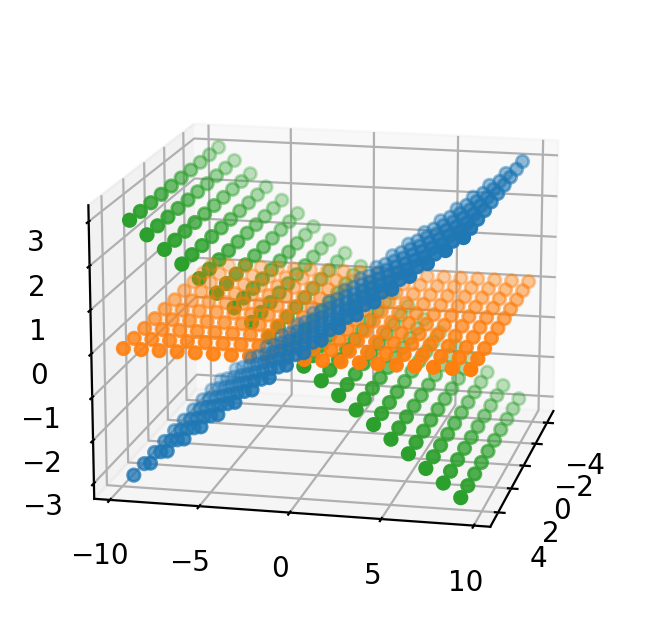

In [106]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
elev = 15.0
azim = 12.5
ax.view_init(elev, azim)
ax.scatter(Qa[0], Qa[1], Qa[2])
ax.scatter(Qb[0], Qb[1], Qb[2])
ax.scatter(Qc[0], Qc[1], Qc[2])
plt.show()

In [107]:
def hest(q1, q2):
    """estimate homography from 2 sets of points"""
    N = q1[0].shape[0]
    K = len(q1)
    B = np.zeros((N*K, N**2))
    def cross_up(x:np.ndarray):
        x1i = x[0].item()
        y1i = x[1].item()
        return np.array([[0, -1, y1i], [1, 0, -x1i], [-y1i, x1i, 0]])

    for i, (q1, q2) in enumerate(zip(q1, q2)):
        q1 = PiInv(q1); q2 = PiInv(q2)
        B[i*N:(i+1)*N] = np.kron(q2.T, cross_up(q1))
    U, S, Vh = np.linalg.svd(B)
    V = Vh.T
    H = V[:,-1].reshape(3,3).T
    H /= -0.01*np.linalg.norm(B) # this is not necessary, 
    # i just do it to make the result the same as the H matrix as before and I just guessed the scaling
    return H

In [108]:
# 4.5
def estimateHomographies(Q_omega:np.ndarray, qs:list):
    """estimate the homographies for all the images

    Q_omega: the points in the world
    qs: list of arrays: the projections of the points in the world in all the images

    returns: a list of homographies, one for each image"""
    homs = []
    for i, q in enumerate(qs):
        # ensure that q is scaled with 1 in last coordinate
        qs = [np.array([q[:,i]]).T for i in range(q.shape[1])]
        Qs = [np.array([Q_omega[:,i]]).T for i in range(Q_omega.shape[1])]
        Qs = PiInv(Qs)
        # drop z coordinate from Q, wjile treating as homogeneous coordinates
        Qs = [np.delete(Q, 2, axis=0) for Q in Qs]
        homs.append(hest(Qs, qs))
    return homs
    
homs = estimateHomographies(Q_omega, [qa, qb, qc])
homs

[array([[-0.000, -0.000, 0.001],
        [0.000, -0.000, -0.000],
        [-0.000, 0.000, -0.000]]),
 array([[0.000, 0.000, -0.001],
        [-0.000, 0.000, 0.000],
        [-0.000, 0.000, 0.000]]),
 array([[-0.000, -0.000, 0.001],
        [0.000, -0.000, -0.000],
        [0.000, -0.000, -0.000]])]

In [109]:
qa.shape

(2, 200)

In [110]:
qa_est = Pi(homs[0] @ Q_omega) # should be the same as qa
qa_est.shape

(2, 200)

In [111]:
qa_est

array([[-86.175, -100.025, -123.107, -169.273, -307.768,
        49842605329466.500, 246.215, 107.719, 61.554, 38.471, 24.621,
        15.388, 8.793, 3.847, -0.000, -3.078, -5.596, -7.694, -9.470,
        -10.992, -66.683, -73.864, -84.636, -102.589, -138.496, -246.215,
        49838051621976.719, 184.661, 76.942, 41.036, 23.083, 12.311,
        5.129, -0.000, -3.847, -6.839, -9.233, -11.192, -12.824, -14.205,
        -52.760, -56.424, -61.554, -69.248, -82.072, -107.719, -184.661,
        49839417646853.977, 123.107, 46.165, 20.518, 7.694, -0.000,
        -5.129, -8.793, -11.541, -13.679, -15.388, -16.787, -17.953,
        -42.318, -43.967, -46.165, -49.243, -53.859, -61.554, -76.942,
        -123.107, 49842605329466.508, 61.554, 15.388, -0.000, -7.694,
        -12.311, -15.388, -17.587, -19.236, -20.518, -21.544, -22.383,
        -34.196, -34.624, -35.174, -35.906, -36.932, -38.471, -41.036,
        -46.165, -61.554, 49840612980050.930, -0.000, -15.388, -20.518,
        -23.083, -24.

In [112]:
np.allclose(qa, qa_est)

False

In [113]:
# 4.6
def estimate_b(Hs:list):
    """estimate the b vector

    takes a list of homographies Hs and returns the vector b. Form the matrix V. This is the coefficient matrix used to estimate b using SVD

    Hs: list of homographies

    returns: b"""
    N = len(Hs)
    V = np.zeros((N*2, 6))
    for i, H in enumerate(Hs):
        v12 = H[0,1]; v11 = H[0,0]; v22 = H[1,1]
        V[i*2, :] = v12
        V[(i*2)+1, :] = v11-v22
    U, S, Vh = np.linalg.svd(V)
    V = Vh.T
    b = V[:,-1]
    return b

Btrue = np.linalg.inv(K).T @ np.linalg.inv(K)
btrue = Btrue[np.triu_indices(3)]
btrue

array([0.000, 0.000, -0.001, 0.000, -0.001, 2.213])

In [114]:
b_est = estimate_b(homs)
b_est

array([-0.000, 0.000, -0.000, -0.000, 0.707, -0.707])

In [115]:
homs[0][0,1] * btrue

array([-0.000, -0.000, 0.000, -0.000, 0.000, -0.000])

In [116]:
homs[0][0,:].T @ Btrue @ homs[0][0,:] # should be the same as the above

5.885711405904178e-07

In [117]:
# v[1,1] @ btrue = h1.T @ Btrue @ h1

In [118]:
# 4.7
def estimateIntrinsics(Hs:list):
    """estimate the intrinsics

    Hs: list of homographies

    returns: K"""

    b = estimate_b(Hs)
    # B12*B13-B11*B23 / B11*B22-B12**2

    v0 = (b[1]*b[3]-b[0]*b[4]) / (b[0]*b[2]-b[1]**2)
    # B33 - [B13^2+v0*(B12*B13-B11*B23)]/B11
    l = b[5] - (b[3]**2 + v0*(b[1]*b[3]-b[0]*b[4]))/b[0]
    alpha = np.sqrt(l/b[0])
    beta = np.sqrt(l*b[0]/(b[0]*b[2]-b[1]**2))
    gamma = -b[1]*alpha**2*beta/l
    u0 = gamma*v0/beta - b[3]*alpha**2/l
    K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
    return K
K = estimateIntrinsics(homs)
K

C:\Users\andre\AppData\Local\Temp\ipykernel_10528\2299093602.py:14: RuntimeWarning: invalid value encountered in double_scalars
  l = b[5] - (b[3]**2 + v0*(b[1]*b[3]-b[0]*b[4]))/b[0]


array([[nan, nan, nan],
       [0.000, nan, 14.339],
       [0.000, 0.000, 1.000]])

In [119]:
# 4.8
def estimateExtrinsics(K, Hs):
    """estimate the extrinsics

    K: the intrinsics, camera matrix
    Hs: list of homographies

    returns: R, t"""
    l = 1/np.linalg.norm(np.linalg.inv(K) @ Hs[0][:,0])
    Rs = []
    ts = []
    for H in Hs:
        R = np.zeros((3,3))
        R[:,0] = l * np.linalg.inv(K) @ H[:,0]
        R[:,1] = l * np.linalg.inv(K) @ H[:,1]
        R[:,2] = np.cross(R[:,0], R[:,1])
        t = l * np.linalg.inv(K) @ H[:,2]
        Rs.append(R)
        ts.append(t)
        
    return Rs, ts
Rs, ts = estimateExtrinsics(K, homs)

In [120]:
# 4.8.2
def calibratecamera(qs, Q):
    """estimate the camera matrix K

    qs: list of arrays: the projections of the points in the world in all the images
    Q: the points in the world

    returns: K, Rs, ts"""
    # 1. estimate homographies
    Hs = estimateHomographies(Q, qs)
    # 2. estimate K
    K = estimateIntrinsics(Hs)
    # 3. estimate extrinsics
    Rs, ts = estimateExtrinsics(K, Hs)
    return K, Rs, ts

K, Rs, ts = calibratecamera(qs, Q_omega)

C:\Users\andre\AppData\Local\Temp\ipykernel_10528\2299093602.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  l = b[5] - (b[3]**2 + v0*(b[1]*b[3]-b[0]*b[4]))/b[0]
C:\Users\andre\AppData\Local\Temp\ipykernel_10528\2299093602.py:16: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.sqrt(l*b[0]/(b[0]*b[2]-b[1]**2))
C:\Users\andre\AppData\Local\Temp\ipykernel_10528\2299093602.py:18: RuntimeWarning: invalid value encountered in double_scalars
  u0 = gamma*v0/beta - b[3]*alpha**2/l
